In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Solving the rolling-only bifurcation problem

To simplify the platelet rolling model, assume that $d = 0$ and $V = R \Omega$. That is, no slip is allowed between the platelet surface and the wall. Then the bond density ($n$) evolution equation simplifies to $$\frac{\partial n}{\partial t} = V \frac{\partial n}{\partial x} + \frac{V}{R} \frac{\partial n}{\partial \theta} + \alpha(x, \theta) \left(1 - \int_{-\infty}^\infty n(x, \theta) dx \right) - \beta(x, \theta) n.$$

We are looking to find steady state rolling velocities and bond distributions as a function of the applied rolling velocity $V_f$, so set $\frac{\partial n}{\partial t} = 0$:
$$0 = V \frac{\partial n}{\partial x} + \frac{V}{R} \frac{\partial n}{\partial \theta} + \alpha(x, \theta) \left(1 - \int_{-\infty}^\infty n(x, \theta) dx \right) - \beta(x, \theta) n.$$

We can write evolution equations for the coordinates $x$ and $\theta$ using the rolling velocities: $$\frac{dx}{dt} = -V \text{ and } \frac{d\theta}{dt} = -\Omega = -V/R.$$ 

Therefore, $x(t) = -Vt + x_0$ and $\theta(t) = -Vt/R + \theta_0$, then eliminating $t$ we get $\theta(x) = x/R + \theta_0 - x_0/R$. Let's say we can define a density function $\hat{n}$ that only varies as a function of $x$: $\hat{n}(x) = n(x, \theta(x))$. Then note what happens when we take a derivative of $\hat{n}$:
$$\frac{d\hat{n}}{dx} = \frac{\partial n}{\partial x} + \frac{\partial n}{\partial \theta} \frac{d \theta}{d x} = \frac{\partial n}{\partial x} + \frac{1}{R}\frac{\partial n}{\partial \theta}.$$

Multiplying through by $-V$, we get the following:
$$-V\frac{d\hat{n}}{dx} = -V \frac{\partial n}{\partial x} - \frac{V}{R} \frac{\partial n}{\partial \theta} = \alpha(x, \theta(x)) \left(1 - \int_{-\infty}^{\infty} n(x, \theta(x)) dx \right) - \beta(x, \theta(x)) n $$ $$= \alpha(x, \theta(x)) \left(1 - \int_{-\infty}^{\infty} \hat{n}(x) dx \right) - \beta(x, \theta(x)) \hat{n}.$$

If you believe the work above, we have simplified an integro-differential equation in two variables to an IDE in one variable.

## Solving the IDE for $\hat{n}$

From above, we have
$$-V\frac{d\hat{n}}{dx} = \hat{\alpha}(x) \left(1 - \int_{-\infty}^{\infty} \hat{n}(x) dx \right) - \hat{\beta}(x) \hat{n}.$$

This can be solved with the following procedure:
1. Pick a value $I \in [0, 1)$
2. Solve the ODE $-V\frac{dn'}{dx} = \hat{\alpha}(x) \left(1 - I\right) - \hat{\beta}(x) n'$
3. Define $I' = \int_{-\infty}^{\infty} n'(x) dx$
4. Then $\hat{n}(x) = n'(x)/(1 - I + I')$

To see that $\hat{n}(x)$ solves the IDE, substitute $n'(x)/(1 - I + I')$ into the IDE above:
$$-V \frac{d\hat{n}}{dx} = -\frac{V}{1 - I + I'}\frac{dn'(x)}{dx} = \frac{\hat{\alpha}}{1 - I + I'}(1 - I) - \hat{\beta}\frac{n'}{1 - I + I'}.$$

Clearly the 2nd term on the RHS is just $\hat{\beta}(x) \hat{n}$. The 1st term on the RHS simplifies to $\hat{\alpha} \left(1 - \frac{I'}{1 - I + I'}\right)$. Note that from the definition of $I'$, $\frac{I'}{1 - I + I'} = \int_{-\infty}^{\infty} \hat{n}(z) dz$. Therefore $\hat{n}(x)$ solves the IDE.

The Python code below solves the IDE and plots the result using this procedure using $I = 0$.

In [2]:
# Define parameters in the problem
L = 5
R = 1
I = 0
V = 5

In [3]:
def alpha(x):
    # Evaluates the on-rate
    kon0 = 10
    eta = 100
    return kon0*np.exp(-eta/2*((1 - np.cos(x/R))**2 + (np.sin(x/R) - x)**2))

def beta(x):
    # Evaluates the off-rate
    return np.exp(np.sqrt((1 - np.cos(x/R))**2 + (np.sin(x/R) - x)**2))

def fun(x, n):
    return -(alpha(x) - beta(x)*n)/V

In [4]:
steps = 1e5
x_lin = np.linspace(L, -L, num=500)
n_prime = solve_ivp(fun, (L, -L), [0], t_eval=x_lin)

The plot below shows the function $n'(x)$.

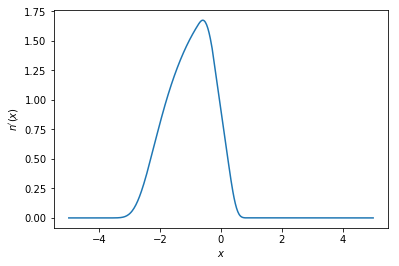

In [5]:
plt.plot(n_prime.t, n_prime.y.T)
plt.xlabel('$x$')
plt.ylabel('$n\'(x)$')
plt.show()

Next, we integrate $n'(x)$ to find $I'$:

In [6]:
I_prime = -np.trapz(n_prime.y, n_prime.t) # The negative sign is necessary 
                                # because n_prime.t is in decreasing order
print(I_prime)

[3.28941586]


Finally, $\hat{n}$ is found by dividing $n'$ by $1 + I'$:

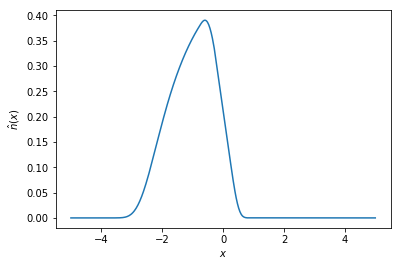

In [7]:
n_hat = n_prime.y.T/(1 + I_prime)
plt.plot(x_lin, n_hat)
plt.xlabel('$x$')
plt.ylabel('$\\hat{n}(x)$')
plt.show()

We can check that $\hat{n}$ satisfies the original IDE:

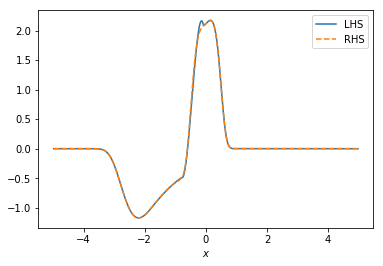

The maximum absolute error is 0.117194


In [8]:
dn_hat = (n_hat[2:] - n_hat[:-2]).T/(x_lin[2:] - x_lin[:-2])
I_hat = -np.trapz(n_hat.T, x_lin)
error = V*dn_hat + (alpha(x_lin[1:-1])*(1 - I_hat)
                    - beta(x_lin[1:-1])*n_hat[1:-1].T)
plt.plot(x_lin[1:-1], -V*dn_hat.T,
         x_lin[1:-1], (alpha(x_lin[1:-1])*(1 - I_hat)
                       - beta(x_lin[1:-1])*n_hat[1:-1].T).T,
         '--')
plt.xlabel('$x$')
plt.legend(['LHS', 'RHS'])
plt.show()
print('The maximum absolute error is {:g}'.format(np.max(error)))